In [2]:
import matplotlib as mpl
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.cm as cm
import numpy as np
import pandas as pd
import warnings
import yaml
from scipy.stats import binned_statistic

In [3]:
from auriga.images import figure_setup, set_axs_configuration, add_redshift
from auriga.snapshot import Snapshot
from auriga.settings import Settings
from auriga.support import make_snapshot_number, multi_color_line
from auriga.parser import parse

In [12]:
figure_setup()

In [5]:
settings = Settings()

In [6]:
config = yaml.safe_load(open(f"../configs/02.yml"))

In [7]:
def get_data(simulation: str, config: dict) -> dict:
    galaxy, rerun, resolution, snapshot = parse(simulation)

    settings = Settings()

    s = Snapshot(simulation=simulation, loadonlytype=[0, 1, 2, 3, 4, 5])
    s.tag_particles_by_region(
        disc_std_circ=config["DISC_STD_CIRC"],
        disc_min_circ=config["DISC_MIN_CIRC"],
        cold_disc_delta_circ=config["COLD_DISC_DELTA_CIRC"],
        bulge_max_specific_energy=config["BULGE_MAX_SPECIFIC_ENERGY"])
    s.tag_in_situ_stars()

    is_star = (s.type == 4) & (s.stellar_formation_time > 0)
    is_main_obj = (s.halo == s.halo_idx) & (s.subhalo == s.subhalo_idx)

    data = {
        "CylindricalRadius_ckpc": s.rho[is_star & is_main_obj],
        "SphericalRadius_ckpc": s.r[is_star & is_main_obj],
        "zPosition_ckpc": s.pos[is_star & is_main_obj, 2],
        "ComponentTag": s.region_tag[is_star & is_main_obj],
        "IsInSitu": s.is_in_situ[is_star & is_main_obj],
    }

    return pd.DataFrame(data)

In [8]:
df = get_data("au6_or_l4_s127", config)

In [9]:
# Halo 1
is_h1 = df["ComponentTag"] == settings.component_tags["H"]
print(df["IsInSitu"][is_h1].sum() / len(df[is_h1]))

0.4273367771661166


In [18]:
# Halo 2
is_h2 = (df["CylindricalRadius_ckpc"] >= 40.0) \
    | (np.abs(df["zPosition_ckpc"]) >= 10.0)
print(df["IsInSitu"][is_h2].sum() / len(df[is_h2]))

0.2550469407575267


/u/fiza/conda-envs/auriga/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


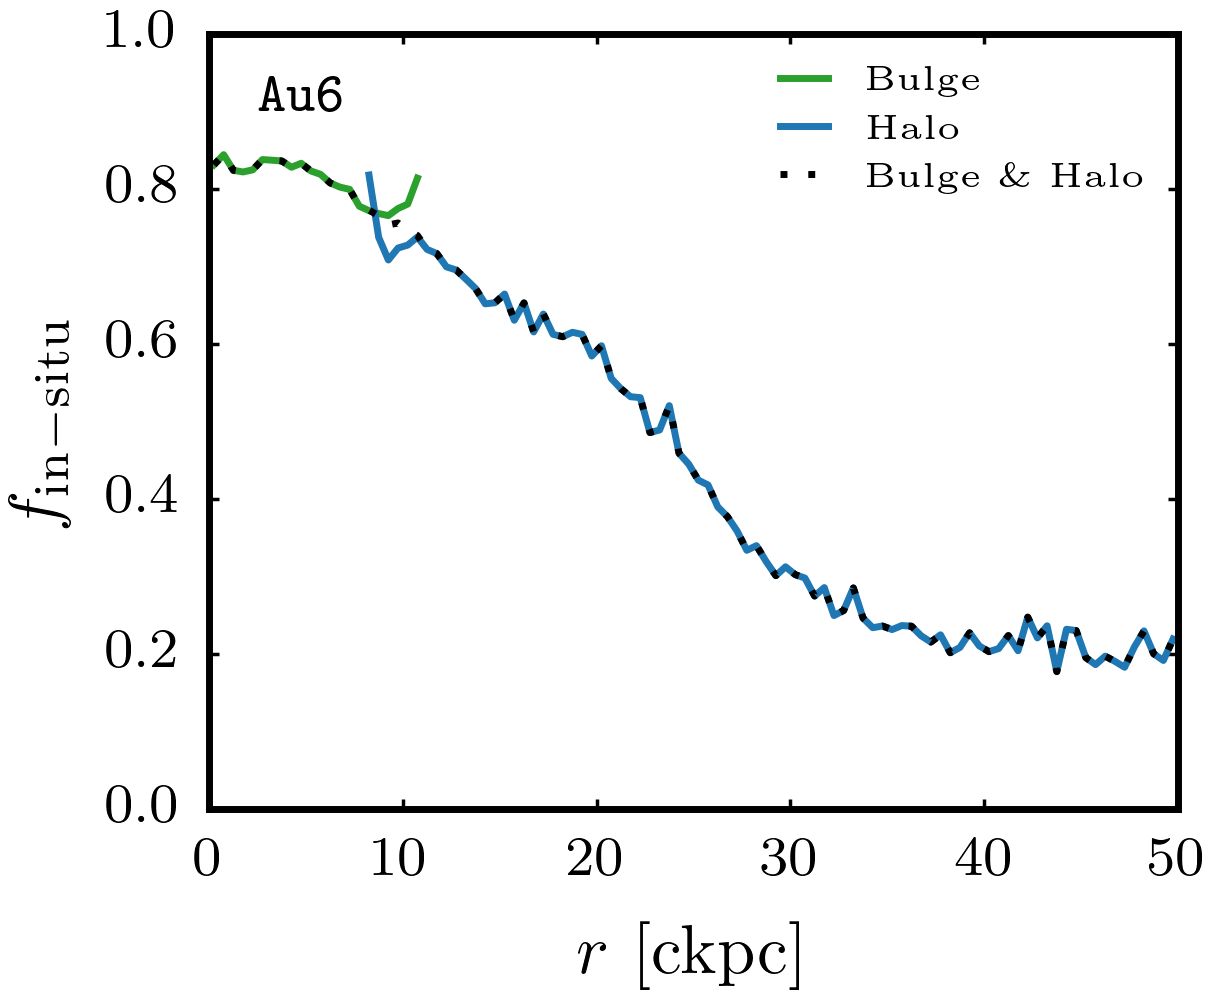

In [17]:
fig, ax = plt.subplots(figsize=(2.5, 2))

label = "Au6"

ax.tick_params(which='both', direction="in")
ax.set_axisbelow(True)

ax.set_xlim(0, 50)
ax.set_xlabel(r"$r$ [ckpc]")
ax.set_ylim(0, 1)
ax.set_ylabel(r"$f_\mathrm{in-situ}$")

for c in ["B", "H"]:
    is_component = df["ComponentTag"] == settings.component_tags[c]
    is_in_situ = df["IsInSitu"] == 1
    count_ins, edges, _ = binned_statistic(
        x=df["SphericalRadius_ckpc"][is_component & is_in_situ],
        values=None,
        statistic="count",
        bins=100,
        range=(0, 50)
    )
    count_tot, edges, _ = binned_statistic(
        x=df["SphericalRadius_ckpc"][is_component],
        values=None,
        statistic="count",
        bins=100,
        range=(0, 50)
    )
    centers = edges[1:] - np.diff(edges) / 2
    ax.plot(centers, count_ins / count_tot,
            color=settings.component_colors[c],
            label=settings.component_labels[c])

is_bulge = df["ComponentTag"] == settings.component_tags["B"]
is_halo = df["ComponentTag"] == settings.component_tags["H"]
count_ins, edges, _ = binned_statistic(
    x=df["SphericalRadius_ckpc"][(is_bulge | is_halo) & is_in_situ],
    values=None,
    statistic="count",
    bins=100,
    range=(0, 50)
)
count_tot, edges, _ = binned_statistic(
    x=df["SphericalRadius_ckpc"][(is_bulge | is_halo)],
    values=None,
    statistic="count",
    bins=100,
    range=(0, 50)
)
centers = edges[1:] - np.diff(edges) / 2
ax.plot(centers, count_ins / count_tot, color="black", ls=":",
        label="Bulge \& Halo")

ax.text(
    x=0.05, y=0.95, s=r"$\texttt{" + label + "}$", zorder=15,
    size=8, transform=ax.transAxes, ha='left', va='top')

ax.legend(loc="upper right", framealpha=0, fontsize=5)

plt.show()